---
---
>>>>>>>>> # بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيم
---
---

# **<u>Master's Thesis</u>**
> - **Date:** *2023.09.01*
> - **Version:** *1.1*
>> - **Prepared by** *Shama Satter*
>> - **Supervised by** *KDK*

# **<u>Initialize Cloud-AI Engine</u>**
> Selected Python version: 3.9.13
>> To access the command line: `py -3.9 -m pip ...`
>>> - Upgrade pip: `py -3.9 -m pip install --upgrade pip`
>>> - Install TensorFlow-GPU (version <2.10): `py -3.9 -m pip install "tensorflow-gpu<2.10"`
>>> - Install TensorFlow Addons (version 0.19.0): `py -3.9 -m pip install tensorflow-addons==0.19.0` [GitHub link](https://github.com/tensorflow/addons)


>>> Install/Verify Packages

In [1]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user openpyxl
# %pip install --user xlrd
# %pip install --user joblib

>>> <b><u>Random Forest with Tree Selection Monte Carlo Based (RF-TSMC)</u></b> [link](https://pypi.org/project/random-forest-mc/)
>>>> This project is about use Random Forest approach for multiclass classification using a dynamic tree selection Monte Carlo based. The first implementation is found in [2] (using Common Lisp).
>>>>> This version of Random Forest makes the selection of trees based on indirect optimization via Monte Carlo simulations. Highly robust against unbalance between classes and missing data (for training and prediction). Optimized for training in parallel processing. Merge native between separate trained models, with simple merge or optimized; thus new models can be mixed with old models generating mixed models (mixing of decision trees), reducing possible new data vieses. This model is highly recommended for EDAs, because it offers a high degree of explainability for PoCs, as it has an excellent relationship between generalization and cost of training and maintenance. Already validated in production, with real data, for churn prediction, with data in the form of time series. In addition, it is excellent for studying Python, because the model is 100% Python code, using some of the most pytonic features! Inspect the code and enjoy!

In [2]:
# %pip install --user -U scikit-learn
# %pip install --user xgboost
# %pip install --user catboost
# %pip install --user lightgbm
# %pip install --user random-forest-mc

>>> Import Libraries

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import sqlalchemy
import mariadb
from matplotlib import pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
import pickle

import tensorflow as tf
from keras import backend
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Bidirectional, GRU, Conv1D
from keras.layers import Concatenate, Dropout, BatchNormalization, Reshape, Flatten
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow_addons.layers import MultiHeadAttention
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

from joblib import dump, load

from collections import defaultdict
from copy import deepcopy
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# __<u>Configure Simulation Setup</u>__

>>> Define `data, model and figure` directory

In [4]:
bigFileDirectory    =   '../BigFile/'
rawDataDirectory    = 'Data/Raw/'
dataDirectory       = 'Data/V1.1/'
modelDirectory      = 'Model/V1.1/'
figureDirectory     = 'Figure/V1.1/'

# create bigDataDirectory directory if it doesn't exist
if not os.path.exists(bigFileDirectory):
    os.makedirs(bigFileDirectory)
    print(f"System has created \"{bigFileDirectory}\" directory.")
else:
    print(f"The directory \"{bigFileDirectory}\" already exists.")

# create rawDataDirectory directory if it doesn't exist
if not os.path.exists(rawDataDirectory):
    os.makedirs(rawDataDirectory)
    print(f"System has created \"{rawDataDirectory}\" directory.")
else:
    print(f"The directory \"{rawDataDirectory}\" already exists.")

# create dataDirectory directory if it doesn't exist
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)
    print(f"System has created \"{dataDirectory}\" directory.")
else:
    print(f"The directory \"{dataDirectory}\" already exists.")

# create modelDirectory directory if it doesn't exist
if not os.path.exists(modelDirectory):
    os.makedirs(modelDirectory)
    print(f"System has created \"{modelDirectory}\" directory.")
else:
    print(f"The directory \"{modelDirectory}\" already exists.")


# create figureDirectory directory if it doesn't exist
if not os.path.exists(figureDirectory):
    os.makedirs(figureDirectory)
    print(f"System has created \"{figureDirectory}\" directory.")
else:
    print(f"The directory \"{figureDirectory}\" already exists.")

The directory "../BigFile/" already exists.
The directory "Data/Raw/" already exists.
The directory "Data/V1.1/" already exists.
The directory "Model/V1.1/" already exists.
The directory "Figure/V1.1/" already exists.


>>> Define columns and rows of pandas output

In [5]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 30)

>>> <u>GPU Configuration for AI Model Running</u>
>>>> To optimize GPU utilization for AI models, we have considered the following options:
>>>> 1. Limiting GPU Memory Growth [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)
>>>> 2. Utilizing Multiple GPUs [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#using_multiple_gpus)
>>>> 3. Running on a Single GPU in a Multi-GPU System [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system)


In [6]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


>>> Specify the GPU that will be used for model execution

In [7]:
selectGPU   = 0
selectedGPU ='/device:GPU:'+ str(selectGPU)
selectedGPU

'/device:GPU:0'

# __<u>User Define Functions</u>__

In [8]:
def feature_n_target_from_one_subject(fileDirectory=r"Data\subject_1.gzip"):
    """
    Extracts and processes Continuous Glucose Monitoring (CGM) and Capillary Blood Glucose (CBG) data from a specified gzip-compressed file. 
    The function organizes the CGM data into intervals of 32 units and computes the mean of non-zero CBG values for each corresponding interval.

    Version:
    - 1.1 (2023.09.04)

    Parameters:
    - fileDirectory (str): Path to the gzip-compressed file containing CGM and CBG data.

    Returns:
    - featureMatrix (numpy array): Matrix containing intervals of CGM data.
    - targetVector  (numpy array): Vector containing the mean of CBG values corresponding to each CGM interval.
    """
    
    # Load the data from the gzip file
    sub = pd.read_csv(fileDirectory, compression="gzip")
    
    # Remove the timestamp column and reset indices
    sub = sub.drop(columns=['timestamp']).reset_index(drop=True)

    # Extract CGM and CBG data
    cgm_data = sub['CGM (mg / dl)'].values
    cbg_data = sub['CBG (mg / dl)'].values

    # Initialize lists to store interval data and mean values
    cgm_intervals   = []
    cbg_mean_values = []

    # Process data in 32-intervals
    for i in range(0, len(cgm_data), 32):
        cgm_interval = cgm_data[i:i+32]
        cbg_interval = cbg_data[i:i+32]

        # Filter out zeros from the cbg_interval
        cbg_interval_no_zeros = cbg_interval[cbg_interval != 0.0]

        # Calculate mean of CBG data for the interval, handling cases where all values might be zero
        cbg_mean = cbg_interval_no_zeros.mean() if cbg_interval_no_zeros.size else 0.0

        # Append to the lists
        cgm_intervals.append(cgm_interval)
        cbg_mean_values.append(cbg_mean)

    # Convert the lists to numpy arrays for returning
    featureMatrix = np.array(cgm_intervals)
    targetVector  = np.array(cbg_mean_values)

    return featureMatrix, targetVector

In [9]:
def check_time_intervals(dataframe):
    """
    Checks if the given dataframe maintains a 15-minute interval for its timestamp column.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe with the timestamp data.

    Returns:
    - (as print) str: Message indicating whether the dataframe maintains the 15-minute interval.
    """
    df = dataframe.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Calculate time difference between rows
    df['diff'] = df['timestamp'].diff()

    # Check if any value is not 15 minutes
    if any(df['diff'][1:] != pd.Timedelta(minutes=15)):
        print("The data does not maintain a 15-minute interval throughout.")
    else:
        print("The data maintains a 15-minute interval throughout.")

In [10]:
def check_valid_CBG_entries(dataframe, group_size=32):
    """
    Checks if every 'group_size' entries in the given dataframe have a valid 'CBG (mg / dl)' data point greater than 0.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe with the 'CBG (mg / dl)' data.
    - group_size (int): Number of rows to group by (default is 32).

    Returns:
    - str: Message indicating whether every 'group_size' entries have a valid 'CBG (mg / dl)' data point.
    """
    
    df = dataframe.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Group by every 'group_size' rows
    grouped = df.groupby(df.index // group_size)['CBG (mg / dl)']

    # Check if any group of 'group_size' has no valid CBG
    is_valid = grouped.apply(lambda group: group.gt(0).any())

    if all(is_valid):
        return f"Every group of {group_size} entries has a valid CBG data point."
    else:
        missing_indices = is_valid[is_valid == False].index
        return f"Not all groups of {group_size} entries have a valid CBG data point. Missing in groups: {', '.join(map(str, missing_indices))}"


In [11]:
def convert_dateTime_column_to_dateTime_format(df, dateTime_columnName, dateTime_format='%Y-%m-%d %H:%M', new_columnName='timestamp'):
    """
    Convert a datetime column in a DataFrame to a specific datetime format and add a new formatted column.
    The original datetime column is dropped, and the new column is placed as the first column.

    Version:
        2.1 (2023.05.24)

    Args:
        df (pandas.DataFrame)       : The DataFrame containing the datetime column.
        dateTime_columnName (str)   : The name of the datetime column to convert.
        dateTime_format (str)       : The desired datetime format (default: '%Y-%m-%d %H:%M').
        new_columnName (str)        : The name of the new column to store the formatted datetime (default: 'timestamp').

    Returns:
        None
    """
    try:
        df[dateTime_columnName] = pd.to_datetime(df[dateTime_columnName], errors='coerce')
        df[new_columnName]      = df[dateTime_columnName].dt.strftime(dateTime_format)
        df[new_columnName]      = pd.to_datetime(df[new_columnName], errors='coerce')
        df.drop(columns=[dateTime_columnName], inplace=True)
        df.insert(0, new_columnName, df.pop(new_columnName))
    except (ValueError, OverflowError):
        df[new_columnName] = np.nan
        print(f"Check {df}")
    
    df = df[pd.notna(df[new_columnName])]

In [12]:
import pandas as pd

def handle_nan_values(dataFrame):
    """
    Print NaN value counts in each column of the DataFrame and handle NaN values.

    Version: 
        1.0 (2023.08.29)

    Args:
        dataFrame (pandas.DataFrame): DataFrame to be processed.

    Returns:
        pandas.DataFrame: Processed DataFrame.
    """
    # Make a copy of original file
    df = dataFrame.copy()
    # Make sure your 'timestamp' column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Count NaN values
    na_counts = df.isna().sum()

    # Print total amount of values
    print("Data Length:")
    print(len(df))

    # If there are NaN values in the DataFrame. Perform actions to handle them.
    if na_counts.any():
        # Print the count of NaN values in each column
        print("NaN Value Counts:")
        print(na_counts)
        print("There are NaN values in the DataFrame. Performing actions...")
        # Replacing with Zero
        df.fillna(0, inplace=True)
        print("NaN values filled with 0.")
    else:
        print("No NaN values found in the DataFrame.")

    return df

In [13]:
def plot_columns_vs_timestamp(df):
    """
    Plot each column of a pandas DataFrame against the timestamp (x-axis), where the x-axis is automatically
    detected based on the dtype of the column. Columns with non-numeric dtypes are ignored.

    Version:
    1.1 (2023.08.29)
    
    Parameters:
    df (pandas DataFrame): The DataFrame to plot.
    """
    # Find the column with the datetime data and set it as the x-axis
    for col_name in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col_name]):
            x_values = df[col_name]
            x_label = col_name
            break
    else:
        print("No datetime column found. Unable to plot.")
        return

    # Make a copy of the DataFrame with the datetime column removed
    numeric_cols = [col_name for col_name in df.columns if pd.api.types.is_numeric_dtype(df[col_name])]
    df_numeric = df[numeric_cols]
        
    # Plot each column against the x-axis
    num_cols = len(df_numeric.columns)
    fig, axs = plt.subplots(num_cols, 1, figsize=(12, 1.3*num_cols), sharex=True)
    fig.set_facecolor(color = 'antiquewhite')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['font.size'] = '9'
    for i, col_name in enumerate(df_numeric.columns):
        axs[i].plot(x_values, df_numeric[col_name], label=col_name, color = 'gray')
        if 'P' in col_name:
            axs[i].set_ylabel('Watt', color='chocolate')
        elif 'T' in col_name:
            axs[i].set_ylabel('DegC', color='chocolate')
        elif 'H' in col_name:
            axs[i].set_ylabel('g/m^3', color='chocolate')
        else:
            axs[i].set_ylabel('Unknown', color='chocolate')
        axs[0].set_title(f'Graphical Representation of {numeric_cols} data', color='brown')
        axs[i].legend(loc="upper right")
        axs[i].grid(True, linestyle='dotted', alpha=0.5, color='salmon')
    plt.xlabel('Timestamp', color='chocolate')
    plt.show()

In [14]:
def plot_data_vs_timeline(df, title, xlabel, ylabel, ylegend1, ylegend2, ycolor, yhight, titleSize, labelSize, figSize, figDPI, maSize):
    """
    Plot a single data column of a pandas DataFrame against the timeline (x-axis), where the timeline is automatically
    detected based on the dtype of the column.

    Version: 
        1.1 (2023.08.29)

    Args:
        df (pandas.DataFrame)   : The DataFrame containing timeseries data.
        title (str)             : Title of the plot.
        xlabel (str)            : Label for the x-axis.
        ylabel (str)            : Label for the y-axis.
        ylegend1 (str)          : Legend label for the data.
        ylegend2 (str)          : Legend label for the moving average data.
        ycolor (str)            : Color for the PV data line.
        yhight (int)            : Set the maximum value of the y-axis.
        titleSize (int)         : Font size of the plot title.
        labelSize (int)         : Font size of the axis labels.
        figSize (tuple)         : Figure size (width, height) in inches.
        figDPI (int)            : DPI (dots per inch) resolution for saving the figure.
        maSize (int)            : Window size for calculating the moving average.

    Returns:
        None
    """

    # Find the column with the datetime data and set it as the x-axis
    for col_name in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col_name]):
            x_values = df[col_name]
            x_label = col_name
            break
    else:
        print("No datetime column found. Unable to plot.")
        return

    # Find the column to plot
    plot_column = None
    for col_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[col_name]):
            plot_column = col_name
            break

    if plot_column is None:
        print("No numeric column found. Unable to plot.")
        return

    # Calculate moving average
    ma_column = df[plot_column].rolling(window=maSize).mean()

    # Plot the column against the x-axis
    fig, ax = plt.subplots(figsize=figSize)
    ax.plot(x_values, df[plot_column],      label=ylegend1,     color=ycolor)
    ax.plot(x_values, ma_column,            label=ylegend2,     color='tan')
    ax.set_xlabel(xlabel, color='black',    fontweight='bold',  fontsize=labelSize)
    ax.set_ylabel(ylabel, color='black',    fontweight='bold',  fontsize=labelSize)
    ax.set_title(title, color='black',      fontweight='bold',  fontsize=titleSize)
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='dotted', alpha=0.5, color='salmon')

    # Set x and y scales
    ax.tick_params(axis='x', labelsize=labelSize, width=2, length=6, direction='inout')
    ax.tick_params(axis='y', labelsize=labelSize, width=2, length=6, direction='inout')
    ax.set_ylim(0, yhight) 
    
    # Save the figure
    figure_directory = figureDirectory
    os.makedirs(figure_directory, exist_ok=True)
    figure_path = os.path.join(figure_directory, f"{title}.png")
    plt.savefig(figure_path, dpi=figDPI)

    plt.show()

# __<u>Data Preprocessing & Analysis</u>__

> ## <u>Creating DataFrame from the `.csv` files in the `Data\Raw\` directory </u>
>> We load individual DataFrame

In [15]:
import pandas as pd
import os
import re

# Directory path
path = 'Data/Raw/'

# Counter for dataframe naming
df_counter = 1

# Iterate through each csv file in the directory
for file in sorted(os.listdir(path)):
    if file.endswith('.csv'):
        # Extract details using regex
        match = re.match(r'(\d{4}.\d{2}.\d{2})-(\w+)-(\w+)-(\d+)mgdL.csv', file)
        
        if match:
            date, subject, meal_status, glucose_level = match.groups()
            
            # Read csv into dataframe
            df = pd.read_csv(path + file)
            
            # Rename the first three columns
            columns = df.columns.tolist()
            rename_dict = {columns[0]: "R", columns[1]: "G", columns[2]: "B"}
            df.rename(columns=rename_dict, inplace=True)
            
            # Drop the unwanted columns
            df.drop(columns=columns[3:6], inplace=True)
            
            # Add extracted columns to dataframe
            df['Date'] = date
            df['Subject Name'] = subject
            df['Meal Status'] = meal_status
            df['Glucose Level (mg/dL)'] = int(glucose_level)
            
            # Reorder columns
            cols_order = ['Date', 'Subject Name', 'Meal Status', 'Glucose Level (mg/dL)', 'R', 'G', 'B']
            df = df[cols_order]
            
            # Assign to global variable dynamically
            globals()[f'df_{df_counter}'] = df
            df_counter += 1

# After processing all files, print the summary
print(f"{df_counter - 1} dataframes were prepared, named from df_1 to df_{df_counter - 1}.")

45 dataframes were prepared, named from df_1 to df_45.


In [16]:
df_1

,Date,Subject Name,Meal Status,Glucose Level (mg/dL),R,G,B
0,2023.08.18,JHM,BE,102,4716.0,4836.0,4792.0
1,2023.08.18,JHM,BE,102,4712.0,4836.0,4788.0
2,2023.08.18,JHM,BE,102,4712.0,4836.0,4792.0
3,2023.08.18,JHM,BE,102,4712.0,4840.0,4792.0
4,2023.08.18,JHM,BE,102,4716.0,4844.0,4796.0
...,...,...,...,...,...,...,...
7720,2023.08.18,JHM,BE,102,4452.0,4596.0,4508.0
7721,2023.08.18,JHM,BE,102,4456.0,4600.0,4512.0
7722,2023.08.18,JHM,BE,102,4456.0,4608.0,4512.0
7723,2023.08.18,JHM,BE,102,4456.0,4612.0,4520.0


In [21]:
# Assuming df_counter holds the number of main dataframes created in the previous code

window_size = 24 * 30  # 30 seconds interval

# Loop through each main dataframe
for i in range(1, df_counter):
    main_df = globals()[f'df_{i}']
    num_windows = int(len(main_df) / window_size)
    
    # Loop to create sub-dataframes
    for j in range(num_windows):
        start_idx = j * window_size
        end_idx = start_idx + window_size
        
        sub_df = main_df.iloc[start_idx:end_idx]
        
        # Assign the sub dataframe to a dynamic global variable
        globals()[f'df_{i}_{j+1}'] = sub_df
        
        # Print the range of indices for the sub-dataframe
        print(f'df_{i}_{j+1} range in df_{i}: {start_idx} to {end_idx - 1}')  # -1 to get the last index in the window

# After this loop, you'll have dataframes named df_1_1, df_1_2,..., df_2_1, df_2_2, and so on. You'll also have printed out the range of indices from the main df_X for each sub-dataframe.


df_1_1 range in df_1: 0 to 719
df_1_2 range in df_1: 720 to 1439
df_1_3 range in df_1: 1440 to 2159
df_1_4 range in df_1: 2160 to 2879
df_1_5 range in df_1: 2880 to 3599
df_1_6 range in df_1: 3600 to 4319
df_1_7 range in df_1: 4320 to 5039
df_1_8 range in df_1: 5040 to 5759
df_1_9 range in df_1: 5760 to 6479
df_1_10 range in df_1: 6480 to 7199
df_2_1 range in df_2: 0 to 719
df_2_2 range in df_2: 720 to 1439
df_2_3 range in df_2: 1440 to 2159
df_2_4 range in df_2: 2160 to 2879
df_2_5 range in df_2: 2880 to 3599
df_2_6 range in df_2: 3600 to 4319
df_2_7 range in df_2: 4320 to 5039
df_2_8 range in df_2: 5040 to 5759
df_2_9 range in df_2: 5760 to 6479
df_2_10 range in df_2: 6480 to 7199
df_3_1 range in df_3: 0 to 719
df_3_2 range in df_3: 720 to 1439
df_3_3 range in df_3: 1440 to 2159
df_3_4 range in df_3: 2160 to 2879
df_3_5 range in df_3: 2880 to 3599
df_3_6 range in df_3: 3600 to 4319
df_3_7 range in df_3: 4320 to 5039
df_3_8 range in df_3: 5040 to 5759
df_3_9 range in df_3: 5760 to 647

In [19]:
df_1_1

,Date,Subject Name,Meal Status,Glucose Level (mg/dL),R,G,B
0,2023.08.18,JHM,BE,102,5680.0,7016.0,6560.0
1,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
2,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
3,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
4,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
...,...,...,...,...,...,...,...
715,2023.08.18,JHM,BE,102,5608.0,6880.0,6440.0
716,2023.08.18,JHM,BE,102,5608.0,6888.0,6444.0
717,2023.08.18,JHM,BE,102,5608.0,6892.0,6448.0
718,2023.08.18,JHM,BE,102,5608.0,6892.0,6448.0


In [80]:
import pandas as pd
import os
import re

# Directory path
path = 'Data/Raw/'

# Counter for dataframe naming
df_counter = 1

# Iterate through each csv file in the directory
for file in sorted(os.listdir(path)):
    if file.endswith('.csv') and "AE" not in file:
        # Extract details using regex
        match = re.match(r'(\d{4}.\d{2}.\d{2})-(\w+)-(\w+)-(\d+)mgdL.csv', file)

        if match:
            date, subject, meal_status, glucose_level = match.groups()

            # Read csv into dataframe
            df = pd.read_csv(os.path.join(path, file))

            # Rename the first three columns
            columns = df.columns.tolist()
            rename_dict = {columns[0]: "R", columns[1]: "G", columns[2]: "B"}
            df.rename(columns=rename_dict, inplace=True)

            # Drop the unwanted columns
            df.drop(columns=columns[3:6], inplace=True)

            # Add extracted columns to dataframe
            df['Date'] = date
            df['Subject Name'] = subject
            df['Meal Status'] = meal_status
            df['Glucose Level (mg/dL)'] = int(glucose_level)

            # Reorder columns
            cols_order = ['Date', 'Subject Name', 'Meal Status', 'Glucose Level (mg/dL)', 'R', 'G', 'B']
            df = df[cols_order]

            # Assign to global variable dynamically
            globals()[f'df_{df_counter}'] = df
            df_counter += 1

# After processing all files, print the summary
print(f"{df_counter - 1} dataframes were prepared, named from df_1 to df_{df_counter - 1}.")

25 dataframes were prepared, named from df_1 to df_25.


In [81]:
df_1

,Date,Subject Name,Meal Status,Glucose Level (mg/dL),R,G,B
0,2023.08.18,JHM,BE,102,5680.0,7016.0,6560.0
1,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
2,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
3,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
4,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
...,...,...,...,...,...,...,...
7914,2023.08.18,JHM,BE,102,5064.0,5608.0,5456.0
7915,2023.08.18,JHM,BE,102,5060.0,5584.0,5440.0
7916,2023.08.18,JHM,BE,102,5052.0,5544.0,5416.0
7917,2023.08.18,JHM,BE,102,5048.0,5508.0,5392.0


In [82]:
# Assuming df_counter holds the number of main dataframes created in the previous code

window_size = 24 * 30  # 30 seconds interval

# Loop through each main dataframe
for i in range(1, df_counter):
    main_df = globals()[f'df_{i}']
    num_windows = int(len(main_df) / window_size)
    
    # Loop to create sub-dataframes
    for j in range(num_windows):
        start_idx = j * window_size
        end_idx = start_idx + window_size
        
        sub_df = main_df.iloc[start_idx:end_idx]
        
        # Assign the sub dataframe to a dynamic global variable
        globals()[f'df_{i}_{j+1}'] = sub_df
        
        # Print the range of indices for the sub-dataframe
        print(f'df_{i}_{j+1} range in df_{i}: {start_idx} to {end_idx - 1}')  # -1 to get the last index in the window

# After this loop, you'll have dataframes named df_1_1, df_1_2,..., df_2_1, df_2_2, and so on. You'll also have printed out the range of indices from the main df_X for each sub-dataframe.

df_1_1 range in df_1: 0 to 719
df_1_2 range in df_1: 720 to 1439
df_1_3 range in df_1: 1440 to 2159
df_1_4 range in df_1: 2160 to 2879
df_1_5 range in df_1: 2880 to 3599
df_1_6 range in df_1: 3600 to 4319
df_1_7 range in df_1: 4320 to 5039
df_1_8 range in df_1: 5040 to 5759
df_1_9 range in df_1: 5760 to 6479
df_1_10 range in df_1: 6480 to 7199
df_2_1 range in df_2: 0 to 719
df_2_2 range in df_2: 720 to 1439
df_2_3 range in df_2: 1440 to 2159
df_2_4 range in df_2: 2160 to 2879
df_2_5 range in df_2: 2880 to 3599
df_2_6 range in df_2: 3600 to 4319
df_2_7 range in df_2: 4320 to 5039
df_2_8 range in df_2: 5040 to 5759
df_2_9 range in df_2: 5760 to 6479
df_2_10 range in df_2: 6480 to 7199
df_2_11 range in df_2: 7200 to 7919
df_3_1 range in df_3: 0 to 719
df_3_2 range in df_3: 720 to 1439
df_3_3 range in df_3: 1440 to 2159
df_3_4 range in df_3: 2160 to 2879
df_3_5 range in df_3: 2880 to 3599
df_3_6 range in df_3: 3600 to 4319
df_3_7 range in df_3: 4320 to 5039
df_3_8 range in df_3: 5040 to 57

In [83]:
df_1_1

,Date,Subject Name,Meal Status,Glucose Level (mg/dL),R,G,B
0,2023.08.18,JHM,BE,102,5680.0,7016.0,6560.0
1,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
2,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
3,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
4,2023.08.18,JHM,BE,102,5680.0,7012.0,6556.0
...,...,...,...,...,...,...,...
715,2023.08.18,JHM,BE,102,5608.0,6880.0,6440.0
716,2023.08.18,JHM,BE,102,5608.0,6888.0,6444.0
717,2023.08.18,JHM,BE,102,5608.0,6892.0,6448.0
718,2023.08.18,JHM,BE,102,5608.0,6892.0,6448.0


In [57]:
# import numpy as np

# # Assuming you have df_1_1 DataFrame
# df_1_1 = df_1_1.drop(['Date', 'Subject Name', 'Meal Status'], axis=1)

# # Convert the DataFrame to a NumPy array
# np_array = df_1_1.to_numpy()

# # Print the resulting NumPy array
# print(np_array)

[[ 102. 5680. 7016. 6560.]
 [ 102. 5680. 7012. 6556.]
 [ 102. 5680. 7012. 6556.]
 ...
 [ 102. 5608. 6892. 6448.]
 [ 102. 5608. 6892. 6448.]
 [ 102. 5608. 6896. 6448.]]


In [58]:
np_array.shape

(720, 4)

In [60]:
np_array[719]

array([ 102., 5608., 6896., 6448.])

In [84]:
import numpy as np

# Determine the highest index for which the corresponding DataFrame exists
highest_index_x = 1
highest_index_y = 1

while True:
    df_name = f'df_{highest_index_x}_{highest_index_y}'
    if df_name in globals():
        highest_index_y += 1
    else:
        highest_index_x -= 1
        break

# Collect the DataFrames into a list
dfs = []

for x in range(1, highest_index_x + 1):
    for y in range(1, highest_index_y + 1):
        df_name = f'df_{x}_{y}'
        if df_name in globals():
            dfs.append(globals()[df_name])

# Remove specified columns and convert to NumPy arrays
np_arrays = [df.drop(['Date', 'Subject Name', 'Meal Status'], axis=1).to_numpy() for df in dfs]

# Combine the NumPy arrays along a new axis (resulting in a shape of (highest_index_x, 720, 4))
combined_np_array = np.stack(np_arrays)

# Print the resulting combined NumPy array shape
print(combined_np_array.shape)

ValueError: need at least one array to stack

In [67]:
combined_np_array[0,0]

array([ 102., 5680., 7016., 6560.])

In [73]:
import numpy as np

# Determine the highest index for which the corresponding DataFrame exists
highest_index = 1
while True:
    df_name = f'df_{highest_index}_{highest_index}'
    if df_name in globals():
        highest_index += 1
    else:
        break

# Collect the DataFrames into a list
dfs = [globals()[f'df_{i}_{i}'] for i in range(1, highest_index)]

# Remove specified columns and convert to NumPy arrays
np_arrays = [df.drop(['Date', 'Subject Name', 'Meal Status'], axis=1).to_numpy() for df in dfs]

# Combine the NumPy arrays along a new axis (resulting in a shape of (highest_index - 1, 720, 4))
combined_np_array = np.stack(np_arrays)

# Print the resulting combined NumPy array shape
print(combined_np_array.shape)

(12, 720, 4)


>> ### <u>Convert Date-Time into Timestamp</u>
>>> using `convert_dateTime_column_to_dateTime_format(df, dateTime_columnName, dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')`

In [16]:
convert_dateTime_column_to_dateTime_format(df=subjects['subject_1'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_2'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_3'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_4'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_5'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_6'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_7'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_8'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_9'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_10'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_11'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_12'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')
convert_dateTime_column_to_dateTime_format(df=subjects['subject_13'], dateTime_columnName='Date', dateTime_format='%Y-%m-%d %H:%M:%S', new_columnName='timestamp')

>> ### <u> Sorting Valid Data </u>
>>> - Removing NaN values: `handle_nan_values(dataFrame)`
>>> - Graphical Analysis: `plot_columns_vs_timestamp`
>>> - Validation of Data Logging Interval: `check_time_intervals`
>>> - Validation of Existance Target Values: `check_valid_CBG_entries`

>>> #### `[✔]` subject_1

Data Length:
640
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    589
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


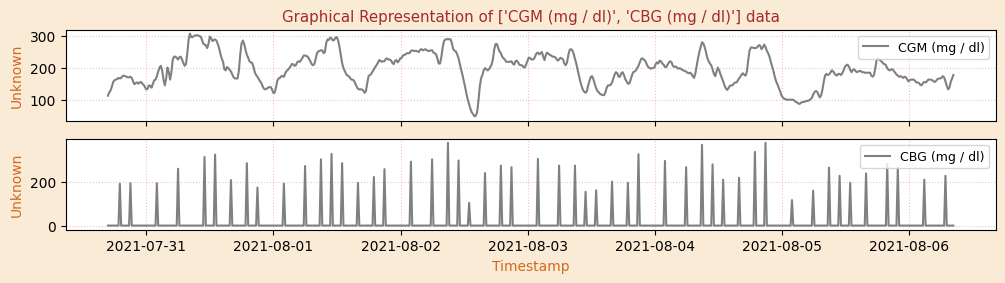

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [17]:
subject_1 = handle_nan_values(subjects['subject_1'][:32*20])
plot_columns_vs_timestamp(subject_1)
check_time_intervals(subject_1)
check_valid_CBG_entries(subject_1)

>>> #### `[✔]` subject_2

Data Length:
928
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    845
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


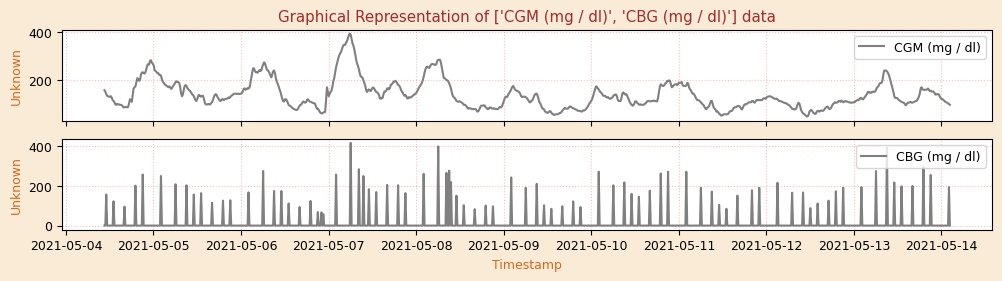

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [18]:
subject_2 = handle_nan_values(subjects['subject_2'][:32*29])
plot_columns_vs_timestamp(subject_2)
check_time_intervals(subject_2)
check_valid_CBG_entries(subject_2)

>>> #### `[✘]` subject_3

Data Length:
864
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    799
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


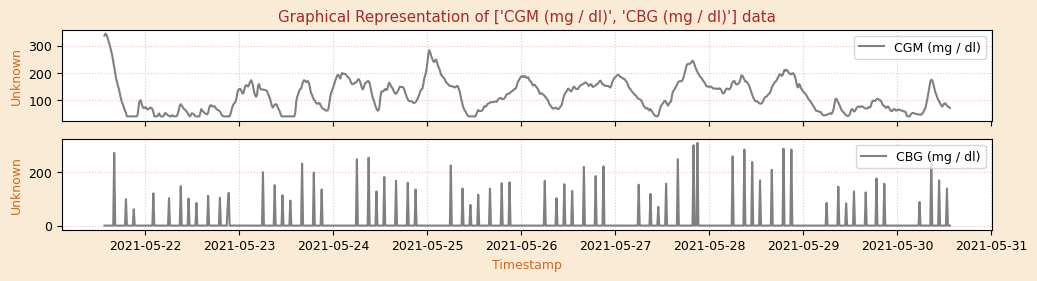

The data does not maintain a 15-minute interval throughout.


'Not all groups of 32 entries have a valid CBG data point. Missing in groups: 4, 7, 10, 13, 16, 19, 22, 25'

In [19]:
subject_3 = handle_nan_values(subjects['subject_3'][:24*36])
plot_columns_vs_timestamp(subject_3)
check_time_intervals(subject_3)
check_valid_CBG_entries(subject_3)

>>> #### `[✔]` subject_4

Data Length:
352
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    327
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


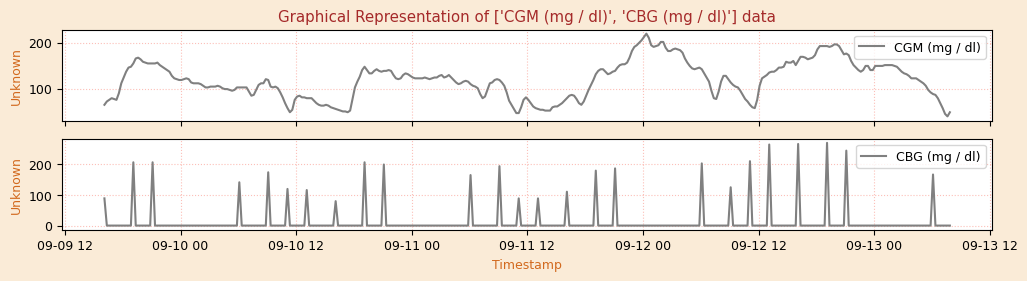

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [20]:
subject_4 = handle_nan_values(subjects['subject_4'][:32*11])
plot_columns_vs_timestamp(subject_4)
check_time_intervals(subject_4)
check_valid_CBG_entries(subject_4)

>>> #### `[✔]` subject_5

Data Length:
1312
NaN Value Counts:
timestamp           0
CGM (mg / dl)       0
CBG (mg / dl)    1215
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


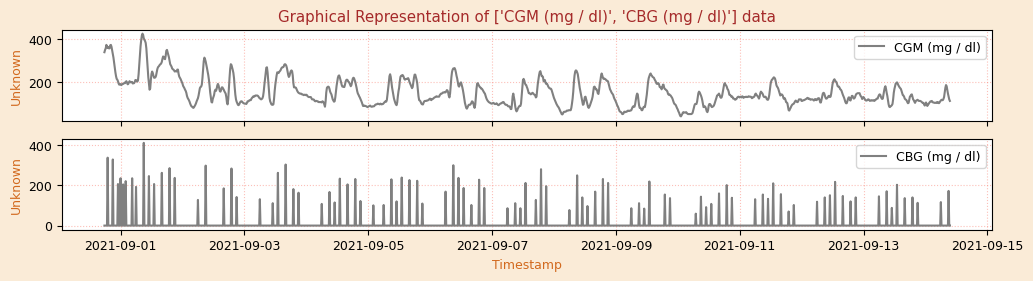

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [21]:
subject_5 = handle_nan_values(subjects['subject_5'][:32*41])
plot_columns_vs_timestamp(subject_5)
check_time_intervals(subject_5)
check_valid_CBG_entries(subject_5)

>>> #### `[✔]` subject_6

Data Length:
896
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    830
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


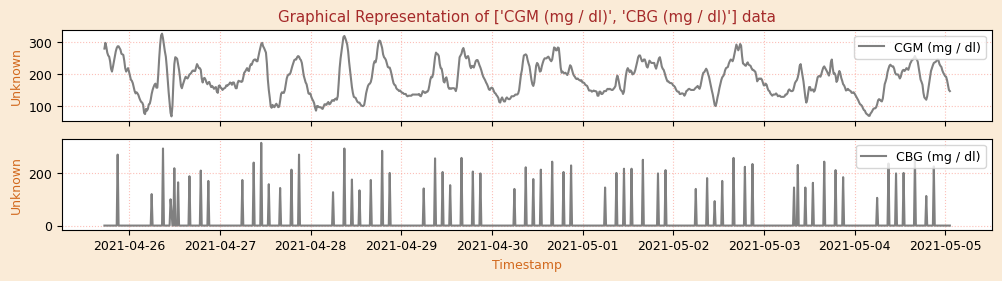

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [22]:
subject_6 = handle_nan_values(subjects['subject_6'][:32*28])
plot_columns_vs_timestamp(subject_6)
check_time_intervals(subject_6)
check_valid_CBG_entries(subject_6)

>>> #### `[✔]` subject_7

Data Length:
608
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    556
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


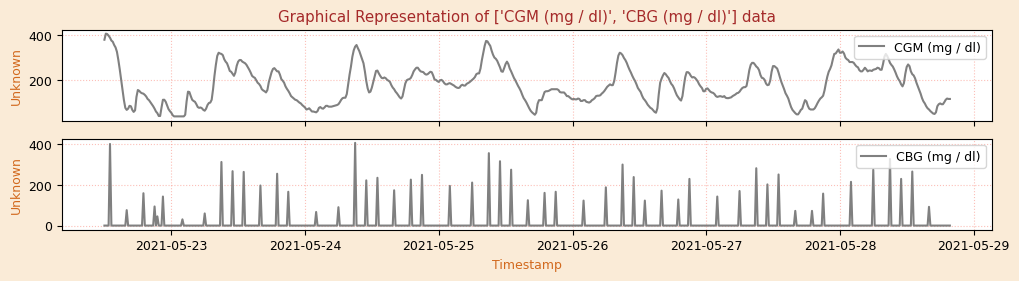

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [23]:
subject_7 = handle_nan_values(subjects['subject_7'][:32*19])
plot_columns_vs_timestamp(subject_7)
check_time_intervals(subject_7)
check_valid_CBG_entries(subject_7)

>>> #### `[✘]` subject_8

Data Length:
1236
NaN Value Counts:
timestamp           0
CGM (mg / dl)       0
CBG (mg / dl)    1231
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


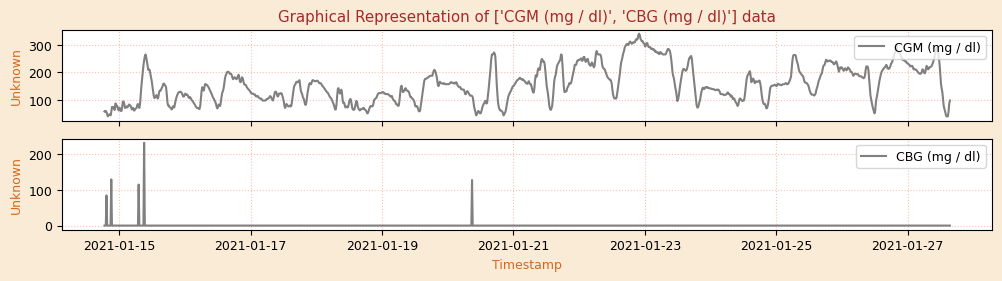

The data maintains a 15-minute interval throughout.


'Not all groups of 32 entries have a valid CBG data point. Missing in groups: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38'

In [24]:
subject_8 = handle_nan_values(subjects['subject_8'])
plot_columns_vs_timestamp(subject_8)
check_time_intervals(subject_8)
check_valid_CBG_entries(subject_8)

>>> #### `[✘]` subject_9

Data Length:
1339
NaN Value Counts:
timestamp           0
CGM (mg / dl)       0
CBG (mg / dl)    1317
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


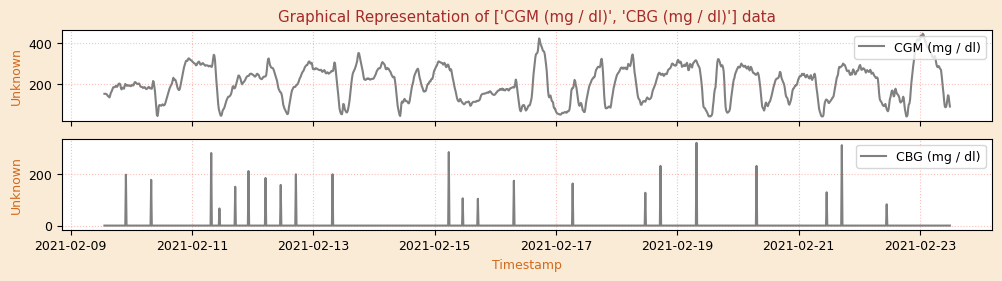

The data maintains a 15-minute interval throughout.


'Not all groups of 32 entries have a valid CBG data point. Missing in groups: 0, 3, 4, 10, 12, 13, 14, 15, 16, 19, 21, 22, 24, 25, 28, 30, 31, 33, 34, 37, 39, 40, 41'

In [25]:
subject_9 = handle_nan_values(subjects['subject_9'])
plot_columns_vs_timestamp(subject_9)
check_time_intervals(subject_9)
check_valid_CBG_entries(subject_9)

>>> #### `[✘]` subject_10

Data Length:
1135
NaN Value Counts:
timestamp           0
CGM (mg / dl)       0
CBG (mg / dl)    1091
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


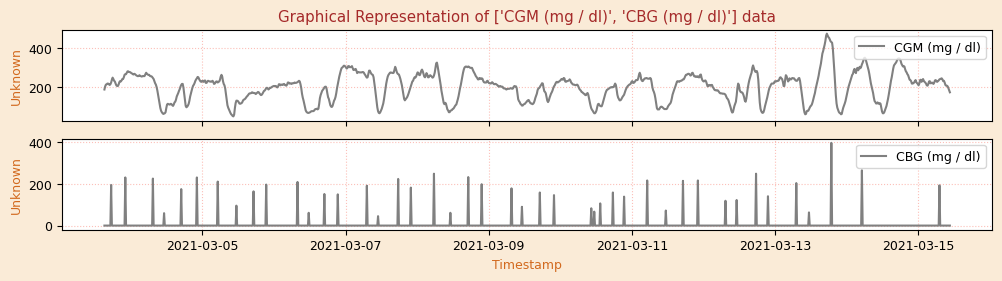

The data maintains a 15-minute interval throughout.


'Not all groups of 32 entries have a valid CBG data point. Missing in groups: 1, 7, 10, 16, 19, 25, 28, 32, 33, 34'

In [26]:
subject_10 = handle_nan_values(subjects['subject_10'])
plot_columns_vs_timestamp(subject_10)
check_time_intervals(subject_10)
check_valid_CBG_entries(subject_10)

>>> #### `[✔]` subject_11

Data Length:
704
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    647
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


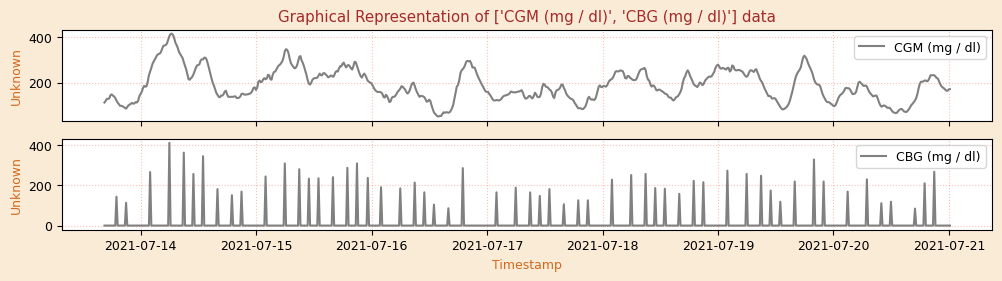

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [27]:
subject_11 = handle_nan_values(subjects['subject_11'][:32*22])
plot_columns_vs_timestamp(subject_11)
check_time_intervals(subject_11)
check_valid_CBG_entries(subject_11)

>>> #### `[✔]` subject_12

Data Length:
672
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    618
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


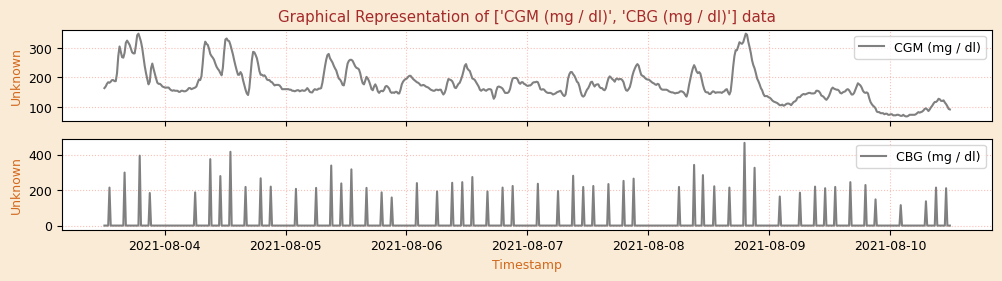

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [28]:
subject_12 = handle_nan_values(subjects['subject_12'][:32*21])
plot_columns_vs_timestamp(subject_12)
check_time_intervals(subject_12)
check_valid_CBG_entries(subject_12)

>>> #### `[✔]` subject_13

Data Length:
736
NaN Value Counts:
timestamp          0
CGM (mg / dl)      0
CBG (mg / dl)    680
dtype: int64
There are NaN values in the DataFrame. Performing actions...
NaN values filled with 0.


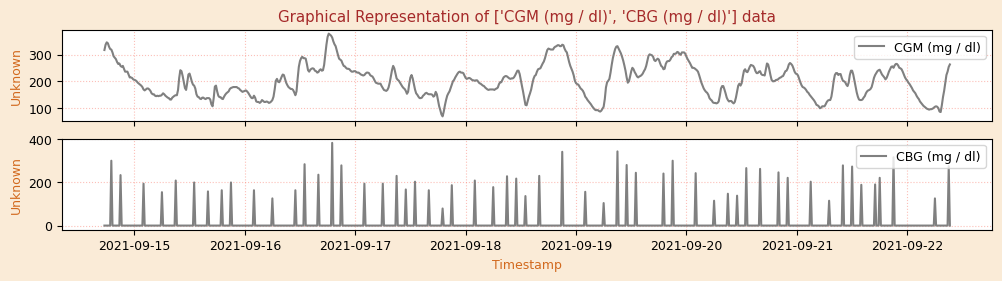

The data maintains a 15-minute interval throughout.


'Every group of 32 entries has a valid CBG data point.'

In [29]:
subject_13 = handle_nan_values(subjects['subject_13'][:32*23])
plot_columns_vs_timestamp(subject_13)
check_time_intervals(subject_13)
check_valid_CBG_entries(subject_13)

>> ### <u> Saving Data </u>

In [30]:
subject_1.to_csv    (f"{dataDirectory}subject_1.gzip",  index=False, compression="gzip")
subject_2.to_csv    (f"{dataDirectory}subject_2.gzip",  index=False, compression="gzip")
subject_4.to_csv    (f"{dataDirectory}subject_3.gzip",  index=False, compression="gzip")
subject_5.to_csv    (f"{dataDirectory}subject_4.gzip",  index=False, compression="gzip")
subject_6.to_csv    (f"{dataDirectory}subject_5.gzip",  index=False, compression="gzip")
subject_7.to_csv    (f"{dataDirectory}subject_6.gzip",  index=False, compression="gzip")
subject_11.to_csv   (f"{dataDirectory}subject_7.gzip",  index=False, compression="gzip")
subject_12.to_csv   (f"{dataDirectory}subject_8.gzip",  index=False, compression="gzip")
subject_13.to_csv   (f"{dataDirectory}subject_9.gzip",  index=False, compression="gzip")

# __<u>Data Preparing for Model Development and Testing</u>__

>> **Note:**
>>   * <u>Summary of the Pre-processed data</u>
>>      * **Subject Count**: `09`
>>      * **CGM (mg / dl)**: `continuous glucose monitoring`
>>      * **CBG (mg / dl)**: `capillary blood glucose`
>
> ## <u> The test and train datasets are prepared as follows: </u>
> 1. Defined a range of subjects from `1 to 9`. This implies we have data from 9 subjects.
> 2. For each subject, data is loaded from files named in the pattern `subject_{subject_number}.gzip`.
> 3. Using the function `feature_n_target_from_one_subject(file_name)`, data is extracted into two separate arrays: `featureMatrix` which contains the features, and `targetVector` which contains the target values.
> 4. The first `7` subjects' data are used for **training**, and the data from the last `2` subjects are used for **testing**.
> 5. All the training datasets (from different subjects) are vertically stacked to create a combined `X_train` and `y_train`. Similarly, the testing datasets are combined to form `X_test` and `y_test`.
> 6. All the datasets (both training and testing) are then combined into a single `X_all` and `y_all` for scaling.
> 7. A `MinMaxScaler` is applied to the combined dataset, and the scaler is saved as `Xy_scaler_model.joblib` for future use.
> 8. The scaled data is then split back into its original structure (`X_train`, `y_train`, `X_test`, and `y_test`).


In [31]:
subjects = range(1, 10)
datasets = {}

# Use first 7 subjects for training
for subject in subjects[:7]:
    file_name = f"{dataDirectory}subject_{subject}.gzip"  # Using double backslashes for the file path
    
    featureMatrix, targetVector = feature_n_target_from_one_subject(file_name)

    datasets[f'X_train_{subject}'] = featureMatrix
    datasets[f'y_train_{subject}'] = targetVector

# Use remaining 2 subjects for testing
for subject in subjects[7:]:
    file_name = f"{dataDirectory}subject_{subject}.gzip"
    
    featureMatrix, targetVector = feature_n_target_from_one_subject(file_name)

    datasets[f'X_test_{subject}'] = featureMatrix
    datasets[f'y_test_{subject}'] = targetVector

# Stacking the datasets for training and testing before scaling
X_train = np.vstack([datasets[f'X_train_{i}'] for i in subjects[:7]])
y_train = np.hstack([datasets[f'y_train_{i}'] for i in subjects[:7]])

X_test = np.vstack([datasets[f'X_test_{i}'] for i in subjects[7:]])
y_test = np.hstack([datasets[f'y_test_{i}'] for i in subjects[7:]])

# Combining all datasets
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])

# Create a combined dataset of X and y for scaling
combined_data = np.column_stack((X_all, y_all))

# Scaling the combined dataset using MinMaxScaler
scaler = MinMaxScaler().fit(combined_data)

# Applying transformation using the trained scaler
combined_scaled = scaler.transform(combined_data)

# Saving the scaler for future use
# modelDirectory = "your_model_directory_path_here"  # Set this to your model directory path
dump(scaler, f'{modelDirectory}Xy_scaler_model.joblib')

# Splitting back the data into its original X and y structure but with scaled values
X_all_scaled = combined_scaled[:, :-1]
y_all_scaled = combined_scaled[:, -1]

# Splitting back into train and test sets using the lengths
X_train_len = X_train.shape[0]
X_test_len  = X_test.shape[0]

X_train = X_all_scaled[:X_train_len]
X_test  = X_all_scaled[X_train_len:]

y_train = y_all_scaled[:X_train_len]
y_test  = y_all_scaled[X_train_len:]

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(170, 32)
(170,)
(44, 32)
(44,)


In [ ]:
X_train

# __<u> Training ML Models </u>__
- Leave One Out Approach
- 4 Models : `RandomForest`, `XGBoost`, `CatBoost` & `LightGBM`

In [34]:
# Define the models to be trained
models = {
    "RandomForest"  : RandomForestRegressor(),
    "XGBoost"       : XGBRegressor(),
    "CatBoost"      : CatBoostRegressor(verbose=0),
    "LightGBM"      : LGBMRegressor()
}

model_performances = defaultdict(list)
model_lists = defaultdict(list)

loo = LeaveOneOut()
num_epochs = loo.get_n_splits(X_train)

for model_name, base_model in models.items():
    mse_values_for_model = []

    for epoch, (train_idx, test_idx) in enumerate(loo.split(X_train), start=1):
        X_loo_train, X_loo_test = X_train[train_idx], X_train[test_idx]
        y_loo_train, y_loo_test = y_train[train_idx], y_train[test_idx]
        
        model = deepcopy(base_model)
        model.fit(X_loo_train, y_loo_train)
        
        y_loo_pred = model.predict(X_loo_test)
        mse_loo = mean_squared_error(y_loo_test, y_loo_pred)
        
        mse_values_for_model.append(mse_loo)
        model_lists[model_name].append(model)

        print(f"Training {model_name} - Epoch {epoch}/{num_epochs} - Current MSE: {mse_loo:.4f}", end="\r", flush=True)

    average_mse = sum(mse_values_for_model) / len(mse_values_for_model)
    model_performances[model_name].extend(mse_values_for_model)  # Store list of MSE values for each model
    
    print(f"\nAverage MSE for {model_name} with LOOCV: {average_mse:.4f}")
    print("-" * 50)

dump(model_performances,    f'{bigFileDirectory}model_performances.joblib')
dump(model_lists,           f'{bigFileDirectory}model_lists.joblib')

Training RandomForest - Epoch 170/170 - Current MSE: 0.0385
Average MSE for RandomForest with LOOCV: 0.0135
--------------------------------------------------
Training XGBoost - Epoch 170/170 - Current MSE: 0.0486
Average MSE for XGBoost with LOOCV: 0.0163
--------------------------------------------------
Training CatBoost - Epoch 170/170 - Current MSE: 0.0194
Average MSE for CatBoost with LOOCV: 0.0133
--------------------------------------------------
Training LightGBM - Epoch 170/170 - Current MSE: 0.0173
Average MSE for LightGBM with LOOCV: 0.0155
--------------------------------------------------


['../BigFile/model_lists.joblib']

# __<u>Innovation</u>__
- weighted_ensemble_predict

In [36]:
model_performances  = load(f'{bigFileDirectory}model_performances.joblib')
model_lists         = load(f'{bigFileDirectory}model_lists.joblib')


def weighted_ensemble_predict(X, models, performances):
    total_weights = sum([1 / mse for mse in performances])
    predictions = np.zeros(X.shape[0])
    for model, mse in zip(models, performances):
        weight = (1 / mse) / total_weights
        predictions += weight * model.predict(X)
    return predictions


for model_type in models.keys():
    y_test_pred_ensemble = weighted_ensemble_predict(X_test, model_lists[model_type], model_performances[model_type])
    mse_ensemble = mean_squared_error(y_test, y_test_pred_ensemble)
    print(f"MSE in the Test Subjects using {model_type} ensemble: {mse_ensemble:.4f}")

MSE in the Test Subjects using RandomForest ensemble: 0.0125
MSE in the Test Subjects using XGBoost ensemble: 0.0114
MSE in the Test Subjects using CatBoost ensemble: 0.0130
MSE in the Test Subjects using LightGBM ensemble: 0.0140


# __<u>Evaluation</u>__

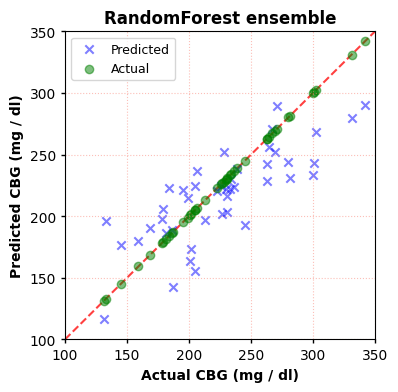

MAE in the Test Subjects using RandomForest ensemble: 25.9698
R^2 in the Test Subjects using RandomForest ensemble: 0.5889


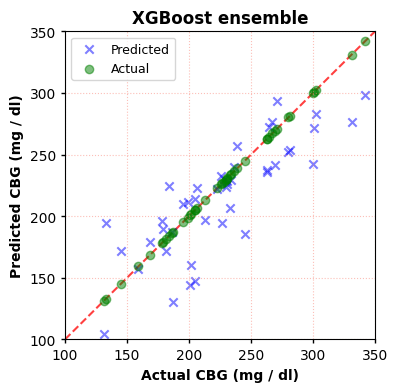

MAE in the Test Subjects using XGBoost ensemble: 23.5754
R^2 in the Test Subjects using XGBoost ensemble: 0.6256


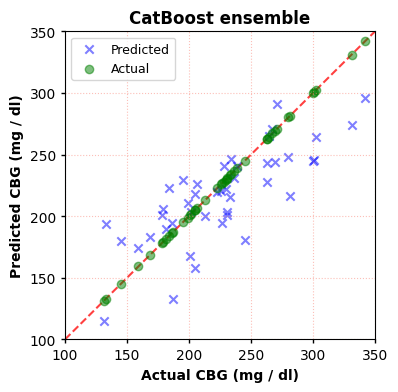

MAE in the Test Subjects using CatBoost ensemble: 26.0820
R^2 in the Test Subjects using CatBoost ensemble: 0.5709


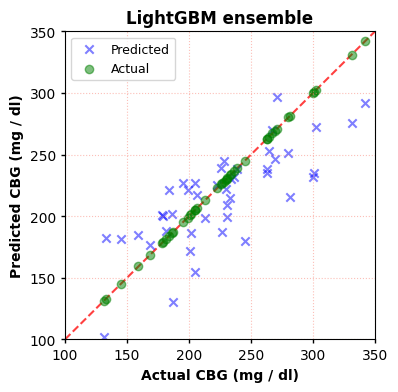

MAE in the Test Subjects using LightGBM ensemble: 27.4880
R^2 in the Test Subjects using LightGBM ensemble: 0.5396


In [35]:
import numpy as np
from joblib import load

# Load the saved scaler
scaler = load(f'{modelDirectory}Xy_scaler_model.joblib')

def inverse_scale_target(scaler, y_scaled):
    # Create a dummy array with zeros with the same shape as the original dataset
    dummy = np.zeros((len(y_scaled), X_train.shape[1]+1))
    
    # Replace the last column (target values) with the scaled values
    dummy[:,-1] = y_scaled
    
    # Use inverse_transform to scale back to the original range
    y_original = scaler.inverse_transform(dummy)[:,-1]
    
    return y_original

for model_type in models.keys():
    y_test_pred_ensemble = weighted_ensemble_predict(X_test, model_lists[model_type], model_performances[model_type])
    
    # Convert the scaled predicted and actual values to their original values
    y_test_original                 = inverse_scale_target(scaler, y_test)
    y_test_pred_ensemble_original   = inverse_scale_target(scaler, y_test_pred_ensemble)
    
    # Scatter plot
    plt.figure(figsize=(4, 4), dpi=100)
    plt.xlim(100, 350)
    plt.ylim(100, 350) 
    plt.scatter(y_test_original, y_test_pred_ensemble_original, alpha=0.5, color='b', label='Predicted', marker='x')
    plt.scatter(y_test_original, y_test_original, alpha=0.5, color='g', label='Actual', marker='o')
    
    # 45-degree line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes
    ]
    plt.plot(lims, lims, '--', alpha=0.75, zorder=0, color='r')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.xlabel('Actual CBG (mg / dl)', fontweight='bold', fontsize=10)
    plt.ylabel('Predicted CBG (mg / dl)', fontweight='bold', fontsize=10)
    plt.title(f'{model_type} ensemble', fontweight='bold', fontsize=12)
    plt.grid(True, linestyle='dotted', color='salmon', alpha=0.5)
    plt.tick_params(axis='x', labelsize=10, width=1, length=3, direction='out')
    plt.tick_params(axis='y', labelsize=10, width=1, length=3, direction='out')
    plt.legend()
    plt.show()

    mse_ensemble    = mean_squared_error(y_test_original, y_test_pred_ensemble_original)
    mae_ensemble    = mean_absolute_error(y_test_original, y_test_pred_ensemble_original)
    r2              = r2_score(y_test_original, y_test_pred_ensemble_original)

    # print(f"MSE in the Test Subjects using {model_type} ensemble: {mse_ensemble:.4f}")
    print(f"MAE in the Test Subjects using {model_type} ensemble: {mae_ensemble:.4f}")
    print(f"R^2 in the Test Subjects using {model_type} ensemble: {r2:.4f}")
